# Chapter 7. Ensemble Learning & Random Forests

- Suppose you pose a random question to thousands of people, then aggregate their answers. In many cases you will find that this aggregated answer is better than an **expert's answer** (*really*).
    - This is called the *wisdom of the crowd*.
- Similarly, if you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than the best individual predictor.
- A group of predictors is called an ensemble. Thus this technique is called **ensemble learning**, and an ensemble learning algorithm is called an **Ensemble Method**.
- As an example of an ensemble method, you can train a group of decision tree classifiers, each on a *random subset* of the training data. 
    - Such an ensemble of decision trees is called a **random forest**. 
    - Despite its simplicity, this is one of the most powerful machine learning algorithms available today.
- You will often use ensemble methods near the end of a project, once you have already built a few good predictors, to combine them into an even better predictor.
- In this chapter, we will discuss the most famous ensemble learning methods, including:
    - **Bagging, Boosting, & Stacking**.

## Voting Classifiers

- Suppose you have trained a few classifiers, each achieving an 80% accuracy.
- A very simple way to create an even better classifiers is to aggregate the predictions of all your classifiers and choose the prediction that is the most frequent.
- This majority voting classifier is called a **Hard Voting** Classifier:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/Hard_voting.png"></div>

- Somewhat surprisingly, this classifier achieves an even better accuracy than the best predictor in the ensemble.
    - Even if each classifier is a weak learner (does slightly better then random guessing).
        - Provided there are a sufficient number of weak learners and enough diversity.
- Due to the law of large numbers, if you build an ensemble containing 1,000 classifiers with individual accuracies of $51%$ & trained for binary classification, If you predict the majority voting class, you can hope for up to $75%$ accuracy.
    - This is only true if all classifiers are completely independent, making uncorrelated errors, which is clearly not the case because they are trained on the same data.
- One way to get diverse classifiers is use different algorithms for each one of them & train them on different subset of the training data. 
- Let's implement a hard voting ensemble learner using scikit-learn:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [3]:
log_clf = LogisticRegression(solver='lbfgs')
rf_clf = RandomForestClassifier(n_estimators=100)
svm_clf = SVC(gamma='scale')

In [4]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [5]:
X, y = datasets.make_moons(n_samples=10000, noise=0.5)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33)

In [6]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((6700, 2), (6700,), (3300, 2), (3300,))

In [7]:
voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)], voting='hard')

In [8]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

- Let's take a look at the performance of each classifier + ensemble method on the validation set:

In [9]:
from sklearn.metrics import accuracy_score

In [10]:
for clf in [log_clf, rf_clf, svm_clf, voting_clf]:
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_val)
    print(clf.__class__.__name__, accuracy_score(y_val, y_hat))

LogisticRegression 0.8084848484848485
RandomForestClassifier 0.7993939393939394
SVC 0.8212121212121212
VotingClassifier 0.8193939393939393


- There you have it! The voting classifier slightly outperforms the individual classifiers.

- If all ensemble method learners can estimate class probabilities, you can average their probabilities per class then predict the class with the highest probability.
    - This is called **Soft voting**.
    - It often yields results better than hard voting because it weights confidence.

## Bagging & Pasting

- Another approach to having different algorithms trained on the same dataset is to have one algorithm but trained on random subsets of the training data.
    - When subset sampling is performed with replacement, this is called **bagging**.
    - When sampling is performed without replacement, this is called **Pasting**.
- Bagging is showcased in the following figure:

<div style="text-align:center;"><img style="width: 50%;" src="static/imgs/bagging.png"></div>

- Once the ensemble method is done training, we can infer using *mode* for classification or *avg* for regression.
- Each individual predictor has a higher bias than if it were trained on the whole training dataset, but aggregation reduces both bias and variance.
- Because ensemble learners use separate different algorithms, they can be easily parallalizable, and that is why bagging and pasting are so popular, they scale very well.

### Bagging & Pasting in Scikit-Learn

- Let's implement bagging in scikit-learn:

In [11]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [12]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

In [13]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [14]:
y_hat = bag_clf.predict(X_val)

- Bagging models often result in a slightly more biased model than the base predictor, but because of the diversity of the training subsets, it has much smoother decision curves meaning it has usually a lower variance
- The comparable/slightly higher bias comes from the fact that we are sampling with replacement, leading to points making it to multiple child learners.
- following is a comparison

<div style="text-align:center;"><img style="width:66%;" src="static/imgs/dt_bagging.png"></div>

- Overall, bagging generally produce better models, and this explains why it's very popular.
    - but if you have compute time and power you can use cross validation to test both bagging and pasting for your case and decide which works better.

### Out-of-Bag Evaluation

- With bagging, some instances will be sampled several times for several predictors, while others won't be sampled at all.
- Only about 63% of the instances are sampled for each predictor.
- The other 37% of instances not sampled are called Out-of-Bag (oob) instances. 
    - Note that they're not the same 37% for all predictors.
- Since the individual predictor never sees the oob samples, it can be evaluated on the oob data without the need for a separate validation set.
- You can evaluate the ensemble itself by averaging the oob scores of each predictor.
- Let's do this using scikit-learn:

In [15]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=0.63, bootstrap=True, n_jobs=-1, oob_score=True)

In [16]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.63, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [17]:
bag_clf.oob_score_

0.8052238805970149

Let's verify this estimation using the validation set:

In [18]:
y_hat = bag_clf.predict(X_val)

In [19]:
accuracy_score(y_val, y_hat)

0.7996969696969697

- Close enough!
- The oob decision function is also available using scikit-learn's API, since our classifier is a decision tree then the decision function is a ratio that can be expressed as a probability, let's take a look at it for each instance:

In [20]:
bag_clf.oob_decision_function_

array([[0.61507937, 0.38492063],
       [0.21126761, 0.78873239],
       [0.01845018, 0.98154982],
       ...,
       [0.78181818, 0.21818182],
       [1.        , 0.        ],
       [0.9962406 , 0.0037594 ]])

## Random Patches & Random Subspaces

- We can sample features as well.
- Sampling is controlled by two hyper-parameters: `max_features` & `bootstrap_features`.
- Thus, each predictor will be trained on a random feature sample.
- This technique is especially useful when you're dealing with high-dimensional input as as imagery. 
- Sample both instances and features is called the random patches method.
- Sampling only features is called the random subspaces method.
- Sampling features results in a more predictor diversity.

## Random Forests

- A random forest is an ensemble of decision trees.
- Let's use its scikit-learn implementation:

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [22]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

In [23]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [24]:
y_pred_rf = rnd_clf.predict(X_val)

- The following `BaggingClassifier` is roughly equivalent to the previous `RandomForestClassifier`:

In [25]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter='random', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### Extra-Trees

- When you are growing a tree in a random forest, only a subset of features are considered when splitting.
- It's possible to make the trees more random by choosing different threshold of the features rather than searching for the best possible threshold.
    - Such a model is called **Extremely Randomized Trees Ensemble**.
- When don't really know if an extremely randomized trees model will or will not outperform a classical random forest model.
    - Generally, the only way to know is to try both and check their results using cross validation.

### Feature Importance

- Yet another great quality of random forests is that they make it so easy to measure the importance of each feature.
- We measure the importance by averaging the reduced impurity of each node that uses a certain feature across all trees in the forest.
    - More exactly it's a weighted average beacuse each node has a number of samples that is used to weight.
- Let's get feature importance using random forests on the iris dataset:

In [26]:
from sklearn.datasets import load_iris

In [27]:
iris = load_iris()

In [29]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [30]:
rnd_clf.fit(iris['data'], iris['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10312810076831765
sepal width (cm) 0.026382587657894523
petal length (cm) 0.42063297937264393
petal width (cm) 0.44985633220114357


- Let's plot pixel-wise MNIST feature importance:

In [32]:
from sklearn.datasets import load_digits

In [33]:
digits = load_digits()

In [34]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [35]:
rnd_clf.fit(digits['data'], digits['target'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

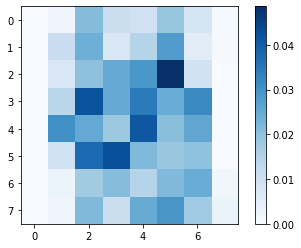

In [39]:
plt.imshow(rnd_clf.feature_importances_.reshape(8,8), cmap='Blues')
plt.colorbar()
plt.show()

- Random Forest are very handy to get a quick understanding of what features actually matter, particularly if you need to perform feature selection.

## Boosting

- Boosting refers to any ensemble method that can combine several weak learners into a strong learner.
- The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 
- There are many boosting methods available, but by far the most popular one is **AdaBoost** (Adaptive boosting) and **gradient boosting**.
- Let's start with Adaboost:

### AdaBoost

- One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that were underfitted.
- this results in the later predictors focusing more and more on the hard cases.
- & This is the technique used by Adaboost.
- The following figure demenstrates the process

<div style="text-align:center;"><img style="width:50%;" src="static/imgs/adaboost.png"></div>

- The algorithm first trains a base classifier and use it to make predictions on the training set. the algorithm then increases the weight of the missclassified instances and pass its weights + the data to the next predictor.
- This iterative learning approach shares similarities with gradient descent, except in gradient descent we're using the gradients to minimize a cost function, but with AdaBoost we're simply adding more learners to the chain.
- There is one important drawback of this method, It cannot be parallalized because each predictor needs the output of the previous predictor.
- ...